# EEG Comfort Score Prediction
 
# This notebook implements an improved approach to predicting comfort scores from EEG features.


## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            roc_curve, precision_recall_curve, 
                            average_precision_score)


import mrmr
from mrmr import mrmr_classif, mrmr_regression

import warnings

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Prepare Data

In [2]:
# Load the data
file_path = "features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

print("Number of Comfort Score == 3:", (labels_shuffled == 3).sum())

# Create binary labels (1,2 = 0; 4,5 = 1; exclude 3 for clearer separation)
binary_labels = labels_shuffled.apply(lambda x: 0 if x <= 2 else (1 if x >=4 else np.nan))
binary_data = data_shuffled[~binary_labels.isna()]
binary_labels = binary_labels[~binary_labels.isna()] ###############################################

Number of Comfort Score == 3: 100


## 3. Data Splitting and Preprocessing

In [3]:
# For binary classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    binary_data,
    binary_labels,
    test_size=0.2,
    stratify=binary_labels,
    random_state=42
)

## 4. Scale features
- Make sure these are used consistently in all future code

In [4]:
scaler = StandardScaler()
X_train_bin_scaled = pd.DataFrame(scaler.fit_transform(X_train_bin))
X_test_bin_scaled = pd.DataFrame(scaler.transform(X_test_bin))

In [5]:
class MRMRTransformer:
    def __init__(self, k_features):
        self.k_features = k_features
        self.selected_features = None
        self.column_names = None
    
    def fit(self, X, y):
        # Convert to DataFrame if not already
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        # Reset indices to avoid alignment issues
        X = X.reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        
        self.column_names = X.columns.tolist()
        try:
            self.selected_features = mrmr_regression(X, y, K=self.k_features)
        except:
            # Fallback to random features if MRMR fails
            self.selected_features = np.random.choice(X.columns, size=min(self.k_features, len(X.columns)), replace=False)
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.column_names)
        return X[self.selected_features]

# Binary Classifcation

In [ ]:
X = X_train_bin_scaled.copy()
y = y_train_bin.copy()

def binary_classification_objective(trial):
    # 1. Imputation
    impute_method = trial.suggest_categorical('imputation', ['mean', 'median', 'knn', 'iterative'])
    if impute_method == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif impute_method == 'median':
        imputer = SimpleImputer(strategy='median')
    elif impute_method == 'knn':
        imputer = KNNImputer(n_neighbors=trial.suggest_int('knn_neighbors', 3, 15))
    else:
        imputer = IterativeImputer(
            max_iter=trial.suggest_int('iterative_max_iter', 10, 50),
            random_state=42,
            tol=0.01
        )

    # 2. Feature selection
    fs_method = trial.suggest_categorical('feature_selection', ['ANOVA', 'MutualInfo', 'RFE', 'None'])
    selector = 'passthrough'  # Default if no feature selection
    
    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 10, min(50, X.shape[1]))
        
        if fs_method == 'ANOVA':
            selector = SelectKBest(f_classif, k=k_features)
        elif fs_method == 'MutualInfo':
            selector = SelectKBest(mutual_info_classif, k=k_features)
        elif fs_method == 'RFE':
            rfe_step = trial.suggest_float('rfe_step', 0.1, 1.0)
            estimator = RandomForestClassifier(
                n_estimators=trial.suggest_int('rfe_n_estimators', 50, 200),
                max_depth=trial.suggest_int('rfe_max_depth', 3, 10),
                random_state=42
            )
            selector = RFE(estimator, n_features_to_select=k_features, step=rfe_step)
    
    # 3. Model selection and hyperparameters
    model_name = trial.suggest_categorical('model', ['RandomForest', 'GradientBoosting', 'XGBoost', 'SVM', 'CatBoost'])
    
    if model_name == 'RandomForest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators_rf', 100, 1000),
            'max_depth': trial.suggest_int('max_depth_rf', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split_rf', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf_rf', 1, 10),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
            'random_state': 42
        }
        model = RandomForestClassifier(**params)
        
    elif model_name == 'GradientBoosting':
        params = {
            'n_estimators': trial.suggest_int('n_estimators_gb', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth_gb', 3, 10),
            'min_samples_split': trial.suggest_int('min_samples_split_gb', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf_gb', 1, 10),
            'subsample': trial.suggest_float('subsample_gb', 0.5, 1.0),
            'random_state': 42
        }
        model = GradientBoostingClassifier(**params)
        
    elif model_name == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators_xg', 100, 1000),
            'max_depth': trial.suggest_int('max_depth_xg', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'subsample': trial.suggest_float('subsample_xg', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma_xg', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'random_state': 42,
            'eval_metric': 'logloss',
            'use_label_encoder': False
        }
        model = XGBClassifier(**params)
        
    elif model_name == 'SVM':
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        params = {
            'C': trial.suggest_float('C', 0.1, 100, log=True),
            'kernel': kernel,
            'gamma': trial.suggest_categorical('gamma_svm', ['scale', 'auto']),
            'degree': trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3,
            'probability': True,
            'random_state': 42
        }
        model = SVC(**params)
        
    else:  # CatBoost
        params = {
            'iterations': trial.suggest_int('catboost_iterations', 100, 1000),
            'depth': trial.suggest_int('catboost_depth', 3, 10),
            'learning_rate': trial.suggest_float('catboost_learning_rate', 0.001, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('catboost_l2_leaf_reg', 1e-8, 10.0, log=True),
            'border_count': trial.suggest_int('catboost_border_count', 32, 255),
            'random_strength': trial.suggest_float('catboost_random_strength', 1e-9, 10, log=True),
            'bagging_temperature': trial.suggest_float('catboost_bagging_temperature', 0.0, 1.0),
            'random_state': 42,
            'verbose': False
        }
        model = CatBoostClassifier(**params)

    # 4. Pipeline
    pipeline = Pipeline([
        ('imputer', imputer),
        ('feature_selection', selector),
        ('model', model)
    ])

    # 5. Cross-validation with proper scoring for classification
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"Error in trial: {e}")
        return -np.inf

# Run binary classification study
binary_study = optuna.create_study(direction='maximize')
binary_study.optimize(binary_classification_objective, n_trials=100, show_progress_bar=True)

# Print results
print("\nBinary Classification Optimization Results:")
print(f"Best ROC AUC: {binary_study.best_value:.4f}")
print("Best Parameters:")
for key, value in binary_study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-08-15 10:18:18,237] A new study created in memory with name: no-name-bd75655c-76eb-48d5-9b0e-0f835ea683da


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-15 10:18:24,693] Trial 0 finished with value: 0.79330977664311 and parameters: {'imputation': 'mean', 'feature_selection': 'None', 'model': 'XGBoost', 'n_estimators_xg': 508, 'max_depth_xg': 3, 'learning_rate': 0.09342845550725178, 'subsample_xg': 0.6323292526581098, 'colsample_bytree': 0.7246541339069184, 'gamma_xg': 0.03788300774379749, 'reg_alpha': 0.303766734150257, 'reg_lambda': 7.495899650191077}. Best is trial 0 with value: 0.79330977664311.
[I 2025-08-15 10:18:26,561] Trial 1 finished with value: 0.7339953256619923 and parameters: {'imputation': 'mean', 'feature_selection': 'ANOVA', 'k_features': 48, 'model': 'XGBoost', 'n_estimators_xg': 691, 'max_depth_xg': 7, 'learning_rate': 0.08985925144923589, 'subsample_xg': 0.9142037911439107, 'colsample_bytree': 0.6206820498591519, 'gamma_xg': 2.5214874153805926, 'reg_alpha': 8.469088209423024, 'reg_lambda': 8.296335781369825}. Best is trial 0 with value: 0.79330977664311.
[I 2025-08-15 10:20:53,455] Trial 2 finished with va

# Apply best imputation and feature selection to training data

In [7]:
# Get best imputation method from study
best_impute_method = binary_study.best_params.get('imputation', 'mean')

# Apply the best imputation method
if best_impute_method == 'mean':
    imputer = SimpleImputer(strategy='mean')
elif best_impute_method == 'median':
    imputer = SimpleImputer(strategy='median')
elif best_impute_method == 'knn':
    imputer = KNNImputer(n_neighbors=binary_study.best_params.get('knn_neighbors', 5))
elif best_impute_method == 'iterative':
    imputer = IterativeImputer(
        max_iter=binary_study.best_params.get('iterative_max_iter', 50),
        random_state=42
    )

# Fit and transform the data
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame (if needed)
if isinstance(X, pd.DataFrame):
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Now apply your feature selection code from before
best_fs_method = binary_study.best_params.get('feature_selection', 'None')

if best_fs_method != 'None':
    k_features = binary_study.best_params['k_features']
    
    if best_fs_method == 'ANOVA':
        selector = SelectKBest(f_classif, k=k_features)
    elif best_fs_method == 'MutualInfo':
        selector = SelectKBest(mutual_info_classif, k=k_features)
    elif best_fs_method == 'RFE':
        estimator = RandomForestRegressor(
            n_estimators=binary_study.best_params.get('rfe_n_estimators', 100),
            max_depth=binary_study.best_params.get('rfe_max_depth', 5),
            random_state=42
        )
        selector = RFE(
            estimator, 
            n_features_to_select=k_features,
            step=binary_study.best_params.get('rfe_step', 1)
        )
    elif best_fs_method == 'MRMR':
        selector = MRMRTransformer(k_features=k_features)
    
    selector.fit(X_imputed, y)

    if hasattr(selector, 'get_support'):  # For SelectKBest/RFE
        selected_features = X.columns[selector.get_support()]
    else:  # For MRMRTransformer
        selected_features = selector.selected_features
    X_best = X_imputed[selected_features]
    
else:
    X_best = X_imputed
    selected_features = X.columns

In [8]:
# Prepare the best model
best_model_name = binary_study.best_params['model']

if best_model_name == 'XGBoost':
    best_model = XGBClassifier(
        n_estimators=binary_study.best_params['n_estimators_xg'],
        max_depth=binary_study.best_params['max_depth_xg'],
        learning_rate=binary_study.best_params['learning_rate'],
        subsample=binary_study.best_params['subsample_xg'],
        colsample_bytree=binary_study.best_params['colsample_bytree'],
        gamma=binary_study.best_params['gamma_xg'],
        reg_alpha=binary_study.best_params['reg_alpha'],
        reg_lambda=binary_study.best_params['reg_lambda'],
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
elif best_model_name == 'RandomForest':
    best_model = RandomForestClassifier(
        n_estimators=binary_study.best_params['n_estimators_rf'],
        max_depth=binary_study.best_params['max_depth_rf'],
        min_samples_split=binary_study.best_params['min_samples_split_rf'],
        min_samples_leaf=binary_study.best_params['min_samples_leaf_rf'],
        class_weight=binary_study.best_params['class_weight'],
        random_state=42
    )
elif best_model_name == 'GradientBoosting':
    best_model = GradientBoostingClassifier(
        n_estimators=binary_study.best_params['n_estimators_gb'],
        max_depth=binary_study.best_params['max_depth_gb'],
        learning_rate=binary_study.best_params['learning_rate'],
        min_samples_split=binary_study.best_params['min_samples_split_gb'],
        min_samples_leaf=binary_study.best_params['min_samples_leaf_gb'],
        subsample=binary_study.best_params['subsample_gb'],
        random_state=42
    )
elif best_model_name == 'SVM':
    best_model = SVC(
        C=binary_study.best_params['C'],
        kernel=binary_study.best_params['kernel'],
        gamma=binary_study.best_params['gamma_svm'],
        degree=binary_study.best_params.get('degree', 3),  # Default degree if not in params
        probability=True,
        random_state=42
    )
else:  # CatBoost
    best_model = CatBoostClassifier(
        iterations=binary_study.best_params['catboost_iterations'],
        depth=binary_study.best_params['catboost_depth'],
        learning_rate=binary_study.best_params['catboost_learning_rate'],
        l2_leaf_reg=binary_study.best_params['catboost_l2_leaf_reg'],
        border_count=binary_study.best_params['catboost_border_count'],
        random_strength=binary_study.best_params['catboost_random_strength'],
        bagging_temperature=binary_study.best_params['catboost_bagging_temperature'],
        random_state=42,
        verbose=False
    )

best_model.fit(X_best, y_train_bin)

GradientBoostingClassifier(learning_rate=0.0094939011482665, max_depth=6,
                           min_samples_leaf=6, min_samples_split=15,
                           n_estimators=305, random_state=42,
                           subsample=0.9833107606317258)

# Apply best model and fit


Final Model Evaluation on Test Set:
Accuracy: 0.6833
Precision: 0.6944
Recall: 0.7576
F1 Score: 0.7246
ROC AUC: 0.7250


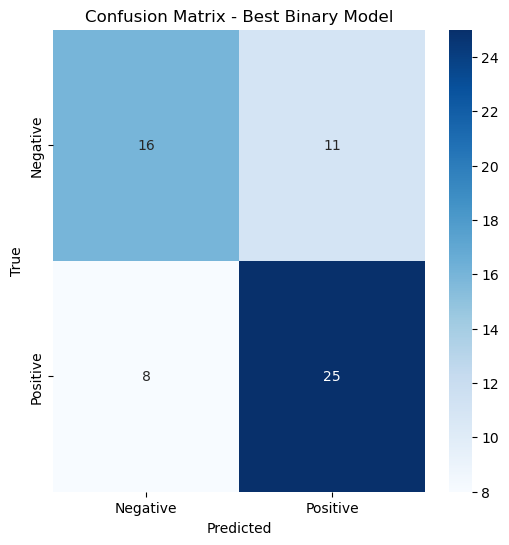

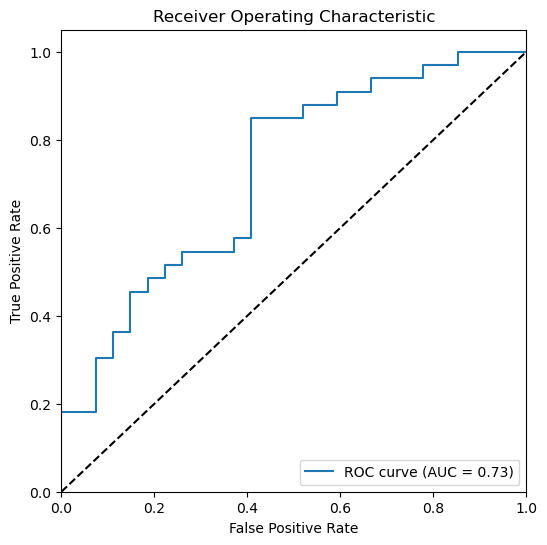

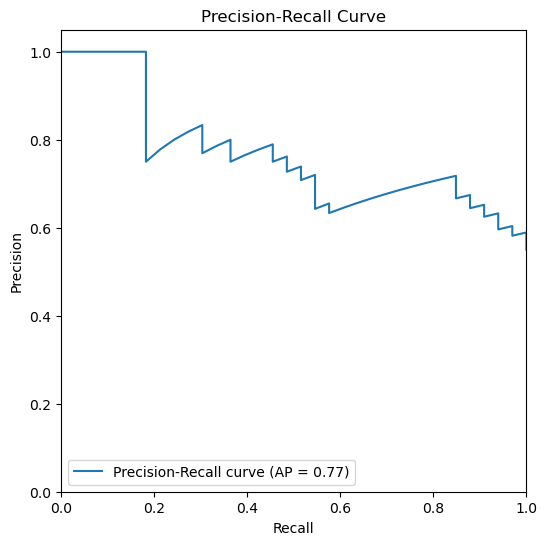

In [9]:
# Prepare test data with same transformations as training
# 1. Apply the same imputation
X_test_imputed = imputer.transform(X_test_bin_scaled)  # Use the already fitted imputer

# Convert back to DataFrame if needed
if isinstance(X_test_bin_scaled, pd.DataFrame):
    X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_bin_scaled.columns)

# 2. Apply the same feature selection
if best_fs_method != 'None':
    if best_fs_method == 'MRMR':
        X_test_final = X_test_imputed[selected_features]
    else:
        X_test_final = selector.transform(X_test_imputed)  # Use the already fitted selector
        if isinstance(X_test_imputed, pd.DataFrame):
            X_test_final = pd.DataFrame(X_test_final, columns=selected_features)
else:
    X_test_final = X_test_imputed

# Make predictions
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]  # Probabilities for class 1

# Calculate metrics
accuracy = accuracy_score(y_test_bin, y_pred)
precision = precision_score(y_test_bin, y_pred)
recall = recall_score(y_test_bin, y_pred)
f1 = f1_score(y_test_bin, y_pred)
roc_auc = roc_auc_score(y_test_bin, y_pred_proba)

print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_bin, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Best Binary Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin, y_pred_proba)
average_precision = average_precision_score(y_test_bin, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()